# Simple DAS plotting
This script aims for quick plotting of DAS data.

In [2]:
# import packages
import h5py
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import csv
import sys
sys.path.append("../utils/")
import DASfuncs

In [4]:
# get files
t_start = datetime.datetime(2023,8,9)
t_end = datetime.datetime(2023,8,11)
path = '../data/DAS/data_1Hz'
files = DASfuncs.get_Onyx_h5(path, t_start, t_end)
print('{} files in directory'.format(len(files)))

31 files in directory


In [5]:
# read the data
time_read, data_read, attrs_read = DASfuncs.read_Onyx_h5_to_list(files, cha_start=None, cha_end=None, t_start=t_start, t_end=t_end, verbose=True)
# concatenate files
t_rec, data_rec, attrs = DASfuncs.comb_Onyx_data(time_read, data_read, attrs_read)

Problems with: ../data/DAS/data_1Hz/decimator3_2023-08-11_08.02.22_UTC.h5
zero-size array to reduction operation maximum which has no identity


In [6]:
# fill contiuous parts of data into array
time_list, data_list = DASfuncs.split_continuous_data(t_rec, data_rec, attrs)
# fill data gaps in array
times_filled, data_filled = DASfuncs.fill_data_gaps(time_list, data_list, attrs, t_format='datetime')

In [7]:
# filtering
sos = scipy.signal.butter(2, 0.1,'lowpass', fs=attrs['PulseRate'], output='sos')
filt_list = [DASfuncs.apply_sosfiltfilt_with_nan(sos, arr, axis=0) for arr in data_list]

In [8]:
times_filled, data_filled = DASfuncs.fill_data_gaps(time_list, filt_list, attrs, t_format='datetime')

In [9]:
data_arr = data_filled
times = DASfuncs.sintela_to_datetime(t_rec)  # Convert timestamp to datetime
dx = attrs['SpatialSamplingInterval']
chas = np.arange(attrs['StartLocusIndex'], attrs['StartLocusIndex']+attrs['NumberOfLoci'])
dists = chas*dx

In [13]:
# Slice data in time and space
# enter water at: 560m, exit water at 7565m
start_dist = 2820 # east ridge at 2820m optical distance
end_dist = 3150 # seafloor from ~3150m optical distance onward

start_time = t_start
end_time = datetime.datetime(2023,8,11)#t_start+datetime.timedelta(hours=12)

t_idx_start = np.argmin(np.abs(times-start_time))
t_idx_end = np.argmin(np.abs(times-end_time))
d_idx_start = np.argmin(np.abs(dists-start_dist))
d_idx_end = np.argmin(np.abs(dists-end_dist))

plot_arr = data_arr[t_idx_start:t_idx_end, d_idx_start:d_idx_end]
plot_times = times[t_idx_start:t_idx_end]
plot_dists = dists[d_idx_start:d_idx_end]

In [14]:
data_norm = plot_arr #- np.nanmedian(plot_arr, axis=0)
# data_norm = data_norm / np.std(data_norm, axis=0)[None,:]

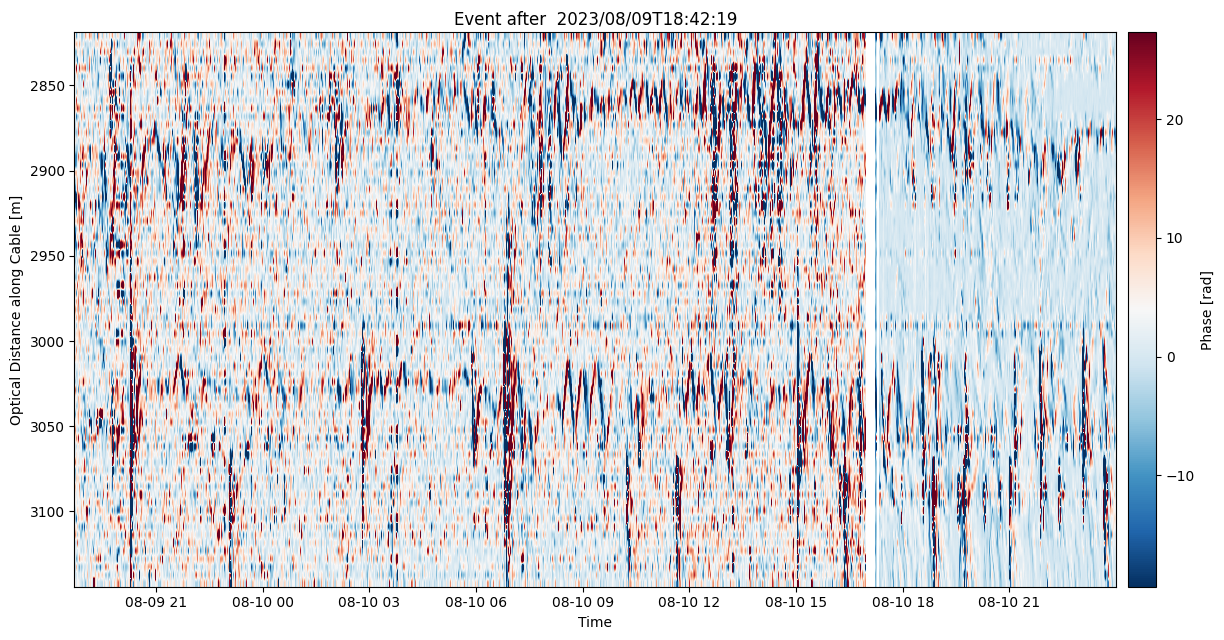

In [15]:
# Plot
fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))

im = ax.imshow(data_norm.T, aspect='auto',
             origin='lower',
             vmin=np.percentile(data_norm[~np.isnan(data_norm)],5),
             vmax=np.percentile(data_norm[~np.isnan(data_norm)],95),
             extent=[plot_times[0], plot_times[-1],
                  plot_dists[0], plot_dists[-1]],
             cmap='RdBu_r',
             # interpolation='none',
               zorder=0
             )

ax.set_ylabel('Optical Distance along Cable [m]')
ax.set_xlabel('Time')
ax.set_title('Event after  {}'.format(plot_times[0].strftime("%Y/%m/%dT%H:%M:%S")))
ax.invert_yaxis()

cbar = fig.colorbar(im, pad=0.01)
cbar.set_label('Phase [rad]')